# Deep Dreaming on Audio Spectrograms with Tensorflow

This notebook uses the [tensorflow primer on DeepDreaming](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb) to adapt [Christian Dittmar & Stefan Balke's DeepDreamEffect for Caffe](http://labrosa.ee.columbia.edu/hamr_ismir2015/proceedings/doku.php?id=deepdreameffect) from [HAMR 2015](http://labrosa.ee.columbia.edu/hamr_ismir2015/) for tensorflow. 

In essence, this hack converts audio spectrograms into images, where they can be processed by specific layers of a pre-trained convulutional neural network ([Inception v3](https://arxiv.org/abs/1512.00567) trained on [ImageNet](https://arxiv.org/abs/1512.00567)) , and then re-synthesized into audio. 

*In simpler terms, it allows a a convnet to hallucinate audio effects based on its learned weights.*

This notebook uses Anaconda 3, Python 3.5 and is powered by [TensorFlow](https://github.com/tensorflow) for deep learning and [Librosa](https://github.com/librosa) for audio DSP.

In [1]:
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import IPython.display
import tensorflow as tf

## Load the pretrained graph and weights

In [2]:
# download the pretrained (on imagenet) inception weights
#! wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [2]:
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

## Filter visualization

To take a glimpse into the kinds of patterns that the network learned to recognize, we will try to generate images that maximize the sum of activations of a particular filter of a particular convolutional layer of the neural network. The network we explore contains many convolutional layers, each of which outputs tens to hundreds of filters, so we have plenty of patterns to explore.

*Let's start with a naive way of visualizing these. Image-space gradient ascent!*

-19.6454 

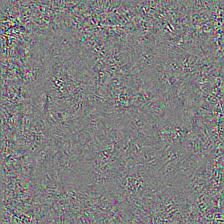

-34.9878 

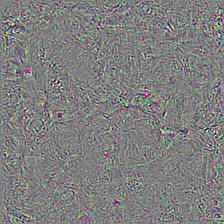

15.2682 

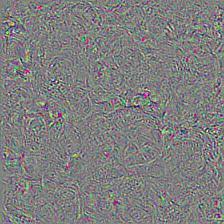

90.4958 

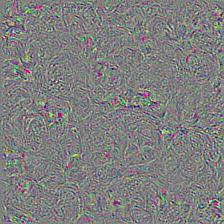

158.858 

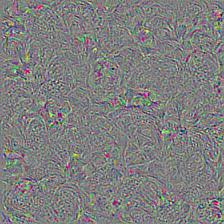

232.851 

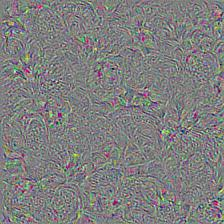

274.185 

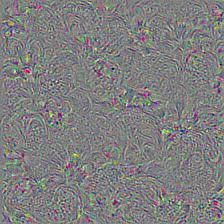

326.823 

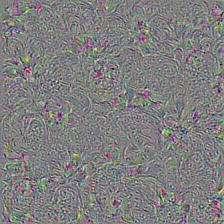

368.311 

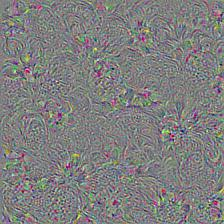

418.732 

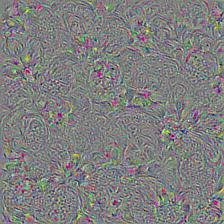

453.237 

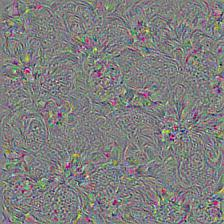

487.034 

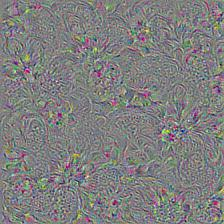

532.701 

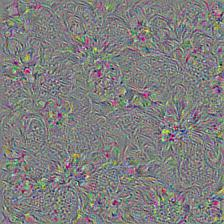

572.253 

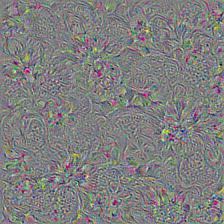

600.151 

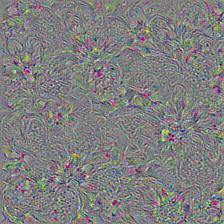

622.814 

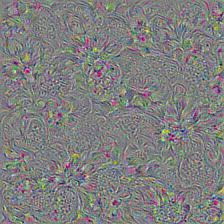

652.045 

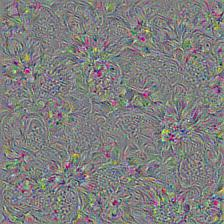

676.845 

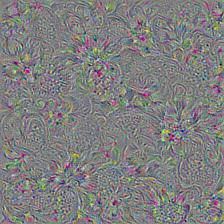

703.309 

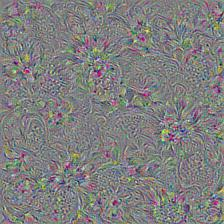

723.937 

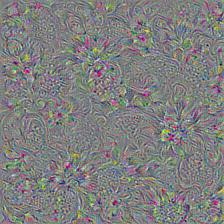

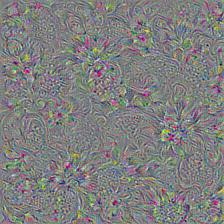

In [3]:
# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    img = img0.copy()
    # defining the optimization objective: maximizing the mean of the filter weights
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    thing = 0
    
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
        showarray(visstd(img))
    #clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:,:,:,channel])

## Multiscale image generation
Looks like the network wants to show us something interesting! Let's help it. We are going to apply gradient ascent on multiple scales. Details formed on smaller scale will be upscaled and augmented with additional details on the next scale.

With multiscale image generation it may be tempting to set the number of octaves to some high value to produce wallpaper-sized images. Storing network activations and backprop values will quickly run out of GPU memory in this case. There is a simple trick to avoid this: split the image into smaller tiles and compute each tile gradient independently. Applying random shifts to the image before every iteration helps avoid tile seams and improves the overall image quality.


In [4]:
# tffunc and resize just use tensorflow operations to resize an image img
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes)) # map all argtypes to a placeholder
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, axis=1), sy, axis=0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)


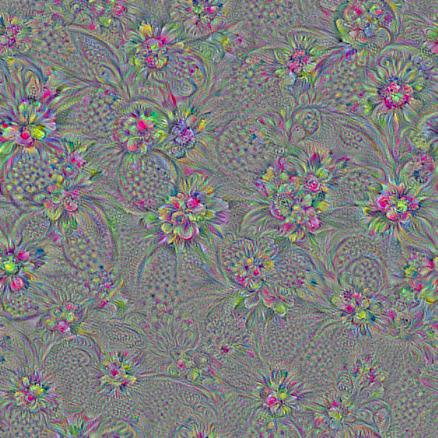

In [9]:
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    # defining the optimization objective: maximizing the mean of the input with values within 20% of max chopped to 0
    t_obj_scaled = tf.mul(t_obj, tf.to_float(tf.log(t_obj) < .8*tf.reduce_max(t_obj))) # and then log'd
    t_score = tf.reduce_mean(t_obj_scaled) # image passed through the filter weights
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))

render_multiscale(T(layer)[:,:,:,channel])


## Laplacian Pyramid Gradient Normalization
This looks better, but the resulting images mostly contain high frequencies. Can we improve it? One way is to add a smoothness prior into the optimization objective. This will effectively blur the image a little every iteration, suppressing the higher frequencies, so that the lower frequencies can catch up. This will require more iterations to produce a nice image. Why don't we just boost lower frequencies of the gradient instead? One way to achieve this is through the [Laplacian pyramid decomposition](https://en.wikipedia.org/wiki/Pyramid_%28image_processing%29#Laplacian_pyramid). We call the resulting technique *Laplacian Pyramid Gradient Normalization*.


In [11]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]
'''
# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)
'''

"\n# Showing the lap_normalize graph with TensorBoard\nlap_graph = tf.Graph()\nwith lap_graph.as_default():\n    lap_in = tf.placeholder(np.float32, name='lap_in')\n    lap_out = lap_normalize(lap_in)\nshow_graph(lap_graph)\n"

## Play with some visualizations!

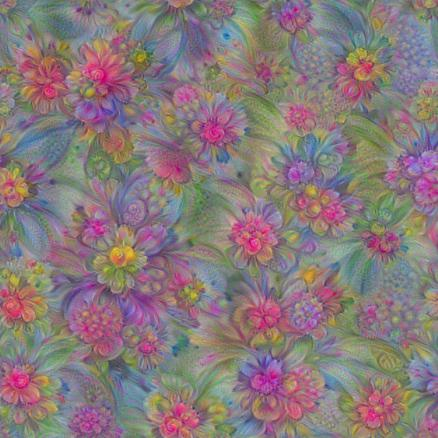

In [12]:
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_obj_scaled = tf.mul(t_obj, tf.to_float(tf.log(t_obj) < .8*tf.reduce_max(t_obj)))
    t_score = tf.reduce_mean(t_obj_scaled) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

render_lapnorm(T(layer)[:,:,:,channel])

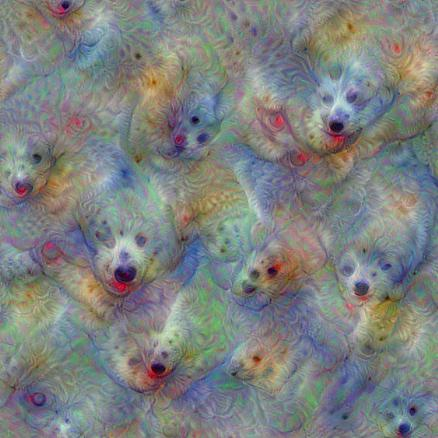

In [18]:
render_lapnorm(T(layer)[:,:,:,45]) #45 is polar bear? 59 is nice. 25 is ok.

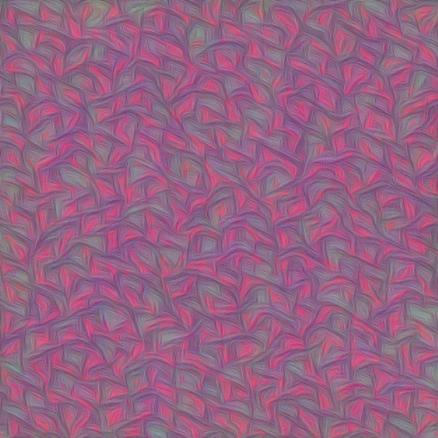

In [17]:
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,10])

## DeepDream
Now let's reproduce the [DeepDream](https://github.com/google/deepdream/blob/master/dream.ipynb) algorithm with TensorFlow

In [13]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=16, octave_scale=1.4):
    t_obj_scaled = tf.mul(t_obj, tf.to_float(tf.log(t_obj) < .8*tf.reduce_max(t_obj)))
    t_score = tf.reduce_mean(t_obj_scaled) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)
    return img/255.0


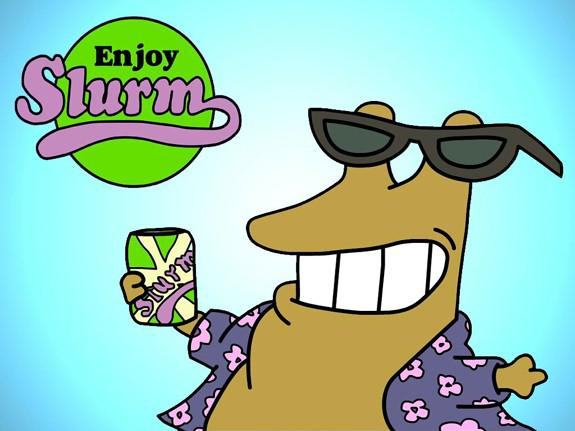

In [14]:
img0 = PIL.Image.open('images/Slurm-1-.jpg')
img0 = np.float32(img0)
showarray(img0/255.0)

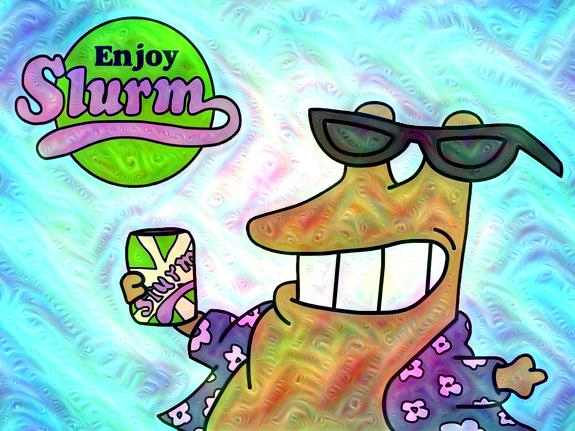

In [15]:
a = render_deepdream(T('mixed3b_1x1_pre_relu')[:,:,:,13], img0)

## Audio funtime!
Now we have all our deepdream helper functions set up in place. We can go ahead and extract an audio spectrogram using the [STFT](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). A spectrogram is simply an NxNx1 matrix, so if we project it to three channels (NxNx3), we can process it in the same way we would any RGB image.

In [17]:
import librosa

# load the audio
y, sr = librosa.load('audio/majid_kaladj_baten.wav', sr=44100)
%matplotlib inline
# do the stft
nfft = 2048
hop = 256
y_stft = librosa.core.stft(y, n_fft = nfft, hop_length = hop, center=True)

# Separate the magnitude and phase
y_stft_mag1, y_stft_ang = librosa.magphase(y_stft)

# scale the spectrogram such that its values correspond to 0-255 (16-bit rgb amplitude)
nonlin = 1.0/8.0
y_stft_mag = np.power(y_stft_mag1, nonlin)
y_stft_mag = np.flipud((1 - y_stft_mag/y_stft_mag.max()))
y_stft_mag_rgb = np.zeros([y_stft_mag.shape[0], y_stft_mag.shape[1], 3])
y_stft_mag_rgb[:, :, 0] = y_stft_mag
y_stft_mag_rgb[:, :, 1] = y_stft_mag
y_stft_mag_rgb[:, :, 2] = y_stft_mag
img = 255*y_stft_mag_rgb

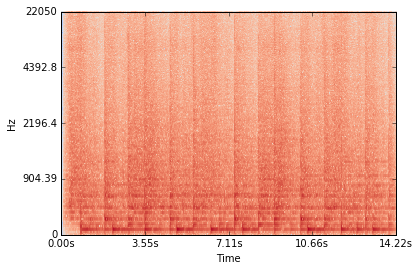

In [18]:
# show original audio log magnitued spectrogram
librosa.display.specshow(data=np.log(np.abs(y_stft_mag1)), sr=sr, x_axis='time', y_axis='log')

In [31]:
# listen to the original audio
IPython.display.Audio(data=y, rate=sr)

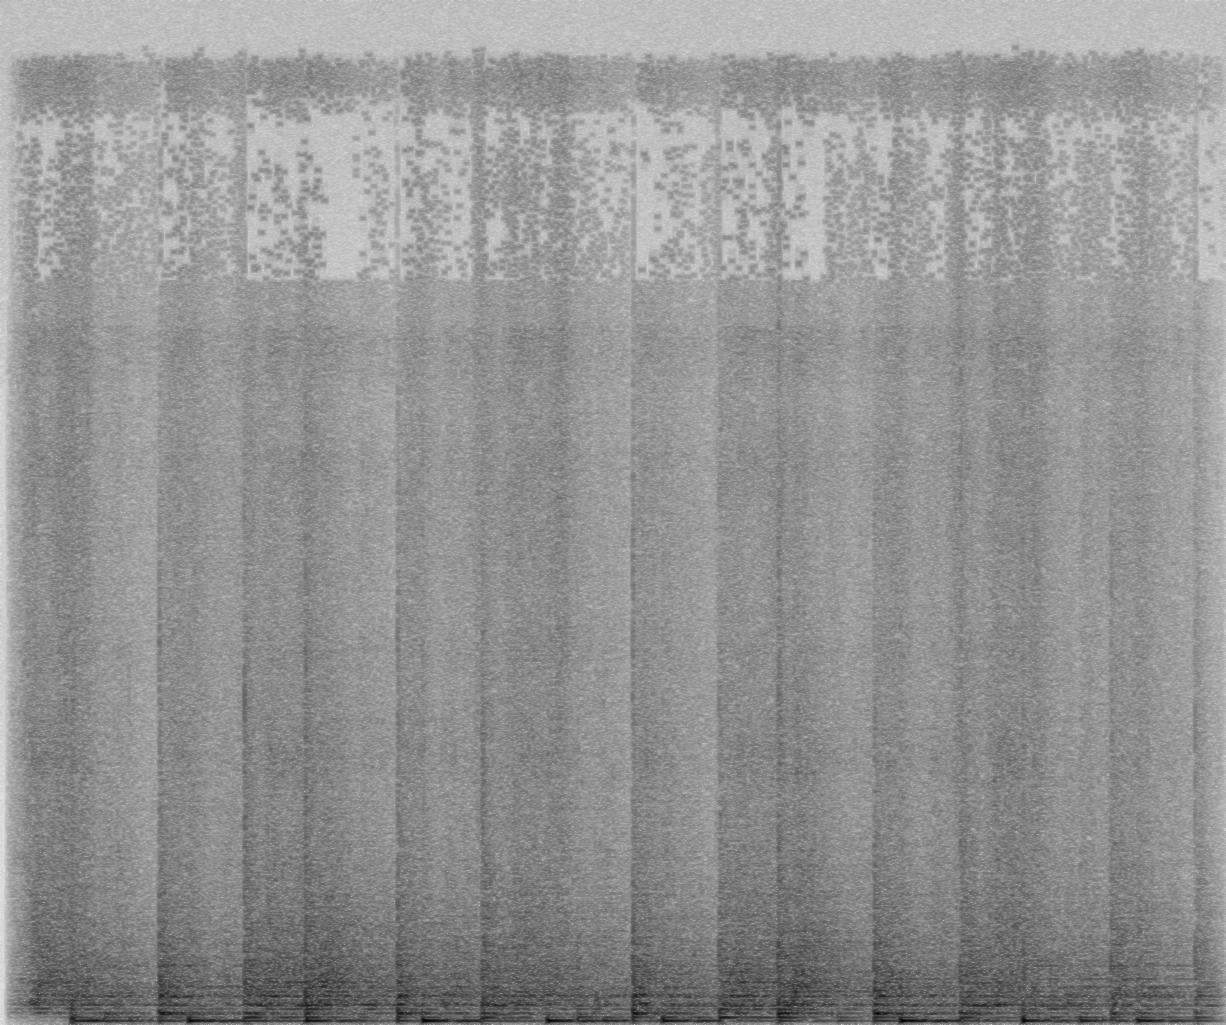

In [19]:
# show the spectrogram as an image i.e. on a linear freq axis
showarray(img/255.0)

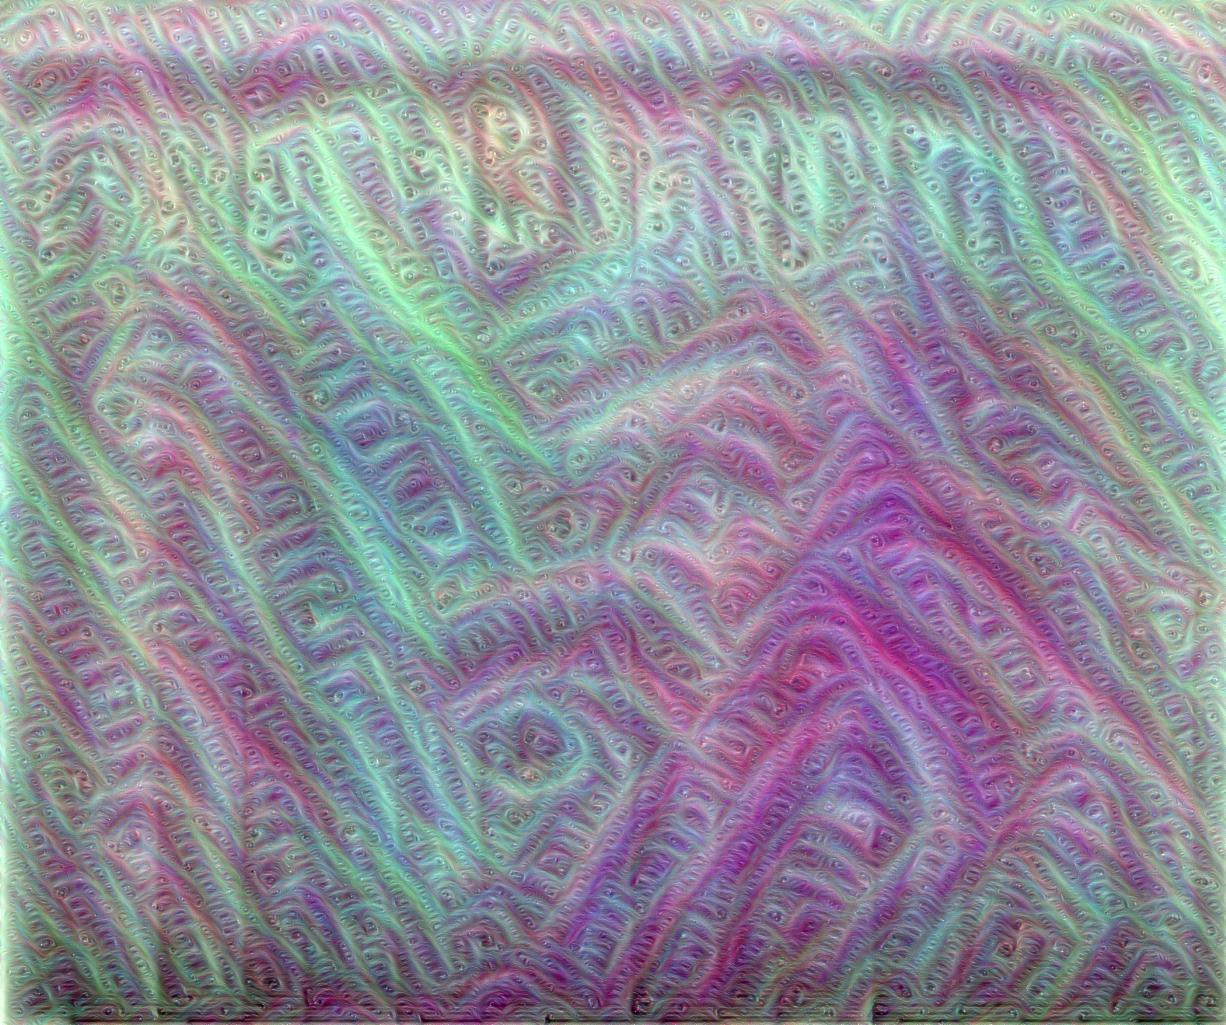

In [20]:
# use the image as an input for deepdream
dream_spec = render_deepdream(T(layer)[:,:,:,channel], img)
dream_spec = render_deepdream(T('mixed3b_1x1_pre_relu')[:,:,:,13], img)

## Resynthesize the spectrogram
Now we're going to resynthesize the spectrogram into audio (time domain). To do this, the first thing  we need to do is reverse all the processing we did to scale the spectrogram tensor into the RGB space.

Since we threw out the [phase](https://en.wikipedia.org/wiki/Phase_%28waves%29), or imaginary part of the FFT in order to visualize the spectrogram, we also have to add that it back in to generate a meaningful reconstruction.

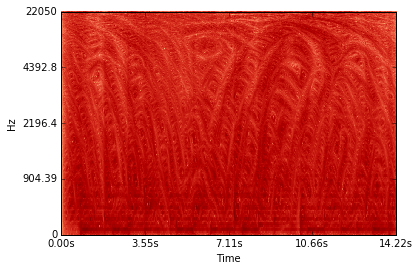

In [22]:
# undo processing to bring the image back from 0-255 to original scale
deepdream_out = np.flipud(dream_spec)
deepdream_out = (1 - deepdream_out) * y_stft_mag.max()
deepdream_out = np.power(deepdream_out, 1/nonlin)
# flatten the three channels and normalize over number of channels
deepdream_out = np.sum(deepdream_out, axis=2) / 3.0
# show the new log-spectrogram
librosa.display.specshow(np.log(np.abs(deepdream_out)), sr=sr, x_axis='time', y_axis='log')

# add back in the original phase
deepdream_out_orig = deepdream_out.copy()
deepdream_out = deepdream_out * y_stft_ang

In [25]:
# listen to the resynthesized without original phase added back in - not very nice... or maybe kinda nice?
output = librosa.core.istft(deepdream_out_orig, hop_length=256, win_length=2048, center=True)
IPython.display.Audio(data=output, rate=sr)

In [ ]:
# save without phase added back in if ya want :)
librosa.output.write_wav('thief_44100_unrefined.wav', output, sr)

In [23]:
# add back in original phase
_, orig_stft_ang = librosa.magphase(y_stft)
deepdream_out = deepdream_out_orig * orig_stft_ang

In [24]:
# play with fixed phase
output = librosa.core.istft(deepdream_out, hop_length=256, win_length=2048, center=True)
IPython.display.Audio(data=output, rate=sr)

In [25]:
#save to disk
librosa.output.write_wav('helix_dreamed_44100.wav', output, sr)